In [1]:
! pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 29.4 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch

In [3]:
# Load dataset
data = pd.read_excel('/kaggle/input/sc-data13/researchdata.xlsx')  # Adjust the path as necessary

# Data Preprocessing
## Check for null values
print("Initial Data Shape:", data.shape)
print("Null Values in Each Column:\n", data.isnull().sum())

## Remove rows with null values
data.dropna(inplace=True)

Initial Data Shape: (5959, 7)
Null Values in Each Column:
 Column1         0
Aspects         0
Adjectives      0
Sub             0
Pol             0
Subjectivity    0
Polarity        0
dtype: int64


In [4]:
## Basic Data Analysis
print("Data Shape after removing nulls:", data.shape)
print("Data Description:\n", data.describe())
#print("Unique Features:", data['Feature'].unique())

## Check for class distribution in Polarity
print("Class Distribution in Polarity:\n", data['Polarity'].value_counts())

# Preprocess data
X = data['Adjectives']  # Using adjectives as input text
y = data['Polarity']    # Using polarity as the target label

Data Shape after removing nulls: (5959, 7)
Data Description:
             Column1           Sub           Pol  Subjectivity     Polarity
count   5959.000000  5.959000e+03  5.959000e+03  5.959000e+03  5959.000000
mean   30785.551938  6.868614e+15  1.906145e+15  1.246614e+12     0.427351
std    19848.823776  1.509981e+16  5.919477e+15  2.666301e+13     0.399703
min        6.000000  0.000000e+00 -3.000000e+16  0.000000e+00    -1.000000
25%    12469.500000  4.000000e+00  4.000000e+00  3.000000e-01     0.136364
50%    27438.000000  9.000000e+00  1.000000e+01  4.750000e-01     0.400000
75%    49733.000000  3.333333e+15  2.500000e+01  6.666667e-01     0.700000
max    62681.000000  4.615385e+16  4.333333e+16  5.714286e+14     1.000000
Class Distribution in Polarity:
 Polarity
 1.000000    1279
 0.500000     909
 0.136364     721
 0.250000     375
 0.700000     229
             ... 
-0.090000       1
-0.013333       1
-0.017857       1
-0.021429       1
 0.150000       1
Name: count, Length: 69

In [5]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [6]:
max_length = 100  # Adjust based on your data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Data Augmentation (Simple Example)
def augment_texts(texts):
    augmented_texts = []
    for text in texts:
        # Simple augmentation: adding noise
        augmented_texts.append(text + " " + np.random.choice(text.split(), size=1)[0])
    return augmented_texts

In [7]:
X_train_augmented = augment_texts(X_train)
X_train_pad_augmented = pad_sequences(tokenizer.texts_to_sequences(X_train_augmented), maxlen=max_length)

# Combine original and augmented data
X_train_combined = np.concatenate((X_train_pad, X_train_pad_augmented))
y_train_combined = np.concatenate((y_train, y_train))

In [8]:
# Build CNN model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', 50, 200, step=50), input_length=max_length))
    model.add(Conv1D(filters=hp.Int('filters', 32, 128, step=32), kernel_size=hp.Int('kernel_size', 3, 7), activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='supplier_selection'
)

tuner.search(X_train_combined, y_train_combined, epochs=20, validation_data=(X_test_pad, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 03m 34s]
val_accuracy: 0.9714764952659607

Best val_accuracy So Far: 0.9742729465166727
Total elapsed time: 00h 36m 51s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
# Train the best model
history = best_model.fit(X_train_combined, y_train_combined, epochs=20, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate the model
y_pred = best_model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

Epoch 1/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9759 - loss: 0.1137 - val_accuracy: 0.9723 - val_loss: 0.3236
Epoch 2/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9730 - loss: 0.1214 - val_accuracy: 0.9748 - val_loss: 0.2778
Epoch 3/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9792 - loss: 0.1047 - val_accuracy: 0.9748 - val_loss: 0.2758
Epoch 4/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9780 - loss: 0.1066 - val_accuracy: 0.9740 - val_loss: 0.2499
Epoch 5/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9814 - loss: 0.1016 - val_accuracy: 0.9740 - val_loss: 0.2351
Epoch 6/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9835 - loss: 0.0936 - val_accuracy: 0.9740 - val_loss: 0.2329
Epoch 7/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9827 - loss: 0.0973 - val_accuracy: 0.9740 - val_loss: 0.1930
Epoch 8/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9811 - loss: 0.1018 - val_accu

In [42]:
def predict_sentiment(text):
    """
    Predict the sentiment for a given input text.
    
    Parameters:
        text (str): The input text to analyze.
        
    Returns:
        sentiment (str): The predicted sentiment label.
    """
    # Preprocess the input text: tokenize and pad the sequence
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_length)
    
    # Predict using the best model
    pred = best_model.predict(padded_seq)
    pred_class = np.argmax(pred, axis=1)[0]
    
    # Convert the numeric class back to the original label
    sentiment = label_encoder.inverse_transform([pred_class])[0]
    return sentiment

# --- Fuzzy Logic Setup (as defined previously) ---
# Define fuzzy variables for supplier evaluation
supplier_quality = ctrl.Antecedent(np.arange(0, 11, 1), 'supplier_quality')
supplier_price = ctrl.Antecedent(np.arange(0, 11, 1), 'supplier_price')
supplier_reliability = ctrl.Antecedent(np.arange(0, 11, 1), 'supplier_reliability')
decision = ctrl.Consequent(np.arange(0, 11, 1), 'decision')

# Automatically generate membership functions for inputs
supplier_quality.automf(3)     # 'poor', 'average', 'good'
supplier_price.automf(3)       # 'cheap', 'average', 'expensive'
supplier_reliability.automf(3)   # 'unreliable', 'average', 'reliable'

# Define membership functions for the decision output
decision['low'] = fuzz.trimf(decision.universe, [0, 0, 5])
decision['medium'] = fuzz.trimf(decision.universe, [0, 5, 10])
decision['high'] = fuzz.trimf(decision.universe, [5, 10, 10])

# Define fuzzy rules
rule1 = ctrl.Rule(supplier_quality['poor'] | supplier_price['poor'] | supplier_reliability['poor'], decision['low'])
rule2 = ctrl.Rule(supplier_quality['average'] | supplier_price['average'] | supplier_reliability['average'], decision['medium'])
rule3 = ctrl.Rule(supplier_quality['good'] & supplier_price['good'] & supplier_reliability['good'], decision['high'])

# Create and initialize the control system simulation
decision_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
decision_evaluator = ctrl.ControlSystemSimulation(decision_ctrl)

# --- Integrated Function: Evaluate Supplier ---
def evaluate_supplier(evaluation_text, price_score, reliability_score):
    """
    Evaluate a supplier by combining the sentiment derived from an evaluation comment
    with additional price and reliability scores using fuzzy logic.
    
    Parameters:
        evaluation_text (str): The supplier evaluation comment.
        price_score (float): Supplier price score (scale 0-10).
        reliability_score (float): Supplier reliability score (scale 0-10).
        
    Returns:
        sentiment (str): Predicted sentiment label.
        quality_score (float): Quality score mapped from sentiment.
        decision_score (float): Final fuzzy logic decision score.
    """
    # 1. Get the predicted sentiment from the evaluation text.
    sentiment = predict_sentiment(evaluation_text)
    
    # 2. Map the sentiment to a numerical quality score.
    quality_score = map_sentiment_to_quality(sentiment)
    
    # 3. Set fuzzy logic inputs.
    decision_evaluator.input['supplier_quality'] = quality_score
    decision_evaluator.input['supplier_price'] = price_score
    decision_evaluator.input['supplier_reliability'] = reliability_score
    
    # 4. Compute the fuzzy decision.
    decision_evaluator.compute()
    decision_score = decision_evaluator.output['decision']
    
    return sentiment, quality_score, decision_score

# --- Example Usage ---
# Example supplier evaluation comment (modify as needed based on your dataset)
evaluation_text = "main"
# Example scores (scale: 0-10) for price and reliability; these could come from other data sources or user input.
price_score = 7  
reliability_score = 8  

# Evaluate the supplier
sentiment, quality_score, decision_score = evaluate_supplier(evaluation_text, price_score, reliability_score)
print("Supplier Evaluation:")
print(f"  Comment: {evaluation_text}")
print(f"  Predicted Sentiment: {sentiment}")
print(f"  Mapped Quality Score: {quality_score}")
print(f"  Fuzzy Decision Score: {decision_score:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Supplier Evaluation:
  Comment: main
  Predicted Sentiment: 0.16666666666666666
  Mapped Quality Score: 5
  Fuzzy Decision Score: 5.00


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
                       precision    recall  f1-score   support

                 -1.0       1.00      0.94      0.97        16
                -0.08       1.00      1.00      1.00        11
 -0.07999999999999999       1.00      1.00      1.00         4
 -0.07142857142857142       1.00      1.00      1.00         5
                -0.07       1.00      0.50      0.67         2
 -0.06999999999999998       1.00      1.00      1.00         5
 -0.06666666666666667       1.00      1.00      1.00         2
              -0.0625       1.00      1.00      1.00         1
                -0.06       1.00      0.95      0.97        19
                -0.05       1.00      0.81      0.89        21
                -0.04       1.00      0.50      0.67        10
 -0.03333333333333333       1.00      1.00      1.00         6
             -0.03125       1.00      1.00      1.00         2
-0.030000000000000002       1.00      1.00      1.00   

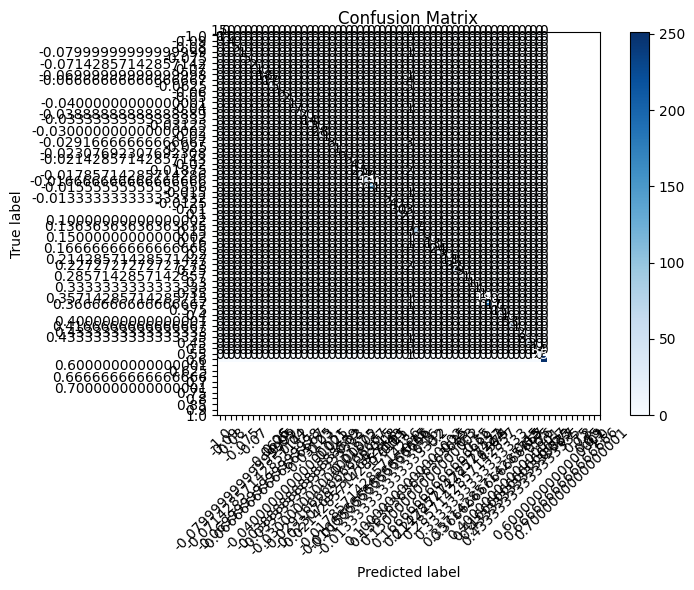

In [27]:
# Import necessary libraries for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the model
y_pred = best_model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get unique classes from the true labels
unique_classes = np.unique(y_test)

# Create a subset of target names that correspond to these unique classes and convert to string
target_names_subset = [str(label_encoder.classes_[int(i)]) for i in unique_classes]

# Print classification report using the subset of target names
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=target_names_subset, labels=unique_classes, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)

# Thresholding for better visualization
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Decision score: 5.095238095238095


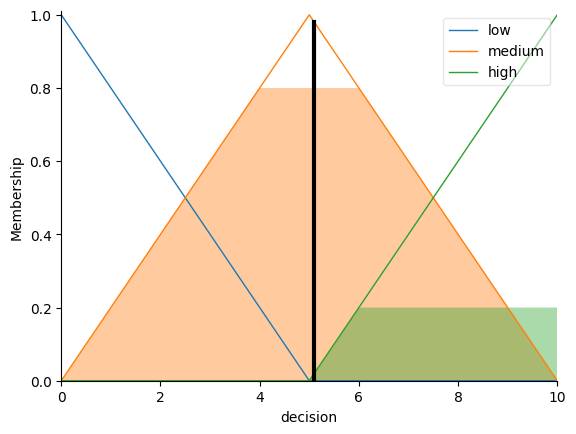

In [20]:
# Example input for decision making
# You can replace these values with actual scores from your dataset
decision_evaluator.input['supplier_quality'] = 7  # Example quality score
decision_evaluator.input['supplier_price'] = 6    # Example price score
decision_evaluator.input['supplier_reliability'] = 8  # Example reliability score

# Compute the decision
decision_evaluator.compute()
print(f"Decision score: {decision_evaluator.output['decision']}")

# Visualize the fuzzy decision output
decision.view(sim=decision_evaluator)

In [30]:
def predict_sentiment(text):
    # Preprocess the input text: tokenize and pad the sequence
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_length)
    
    # Predict using the best model
    pred = best_model.predict(padded_seq)
    pred_class = np.argmax(pred, axis=1)[0]
    
    # Convert the numeric class back to the original label
    sentiment = label_encoder.inverse_transform([pred_class])[0]
    return sentiment

# Example usage:
# This sample sentence is based on the supplier evaluation dataset.
# It might represent a typical comment evaluating a supplier's performance.
sample_text = ("strong")
predicted_sentiment = predict_sentiment(sample_text)
print(f"Input Text: {sample_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Input Text: strong
Predicted Sentiment: 0.4333333333333333
